# Partial differential equations solver (task N2)

## Equation statement

In [843]:
# defining right-hand part and coefficient in the equation

c = lambda x, t: x + np.exp(t)
f = lambda x, t: x * (x + np.exp(t))

boundary = lambda x: x + 1/2*(x**2)
initial  = lambda t: -t

# exact solution
exact    = lambda x, t: x**2/2+x*np.exp(-t) - t

In [844]:
import numpy as np
import pandas as pd

## Main code

In [845]:
# helper class
class Dim:
    def __init__(self, min, max, N):
        self.h   = float(max - min) / N
        self.min = float(min)
        self.max = float(max)
        self.N  = N + 1 # for convinience

    def __getitem__(self, n):
        return self.min + self.h * n

In [846]:
# main part
def calculate(x, t, U, S, F):
    for m in range(1, t.N):
        for n in range(1, x.N):
            U[n, m] = U[n, m-1] * (1 - S[n, m-1]) + \
                      U[n-1, m-1] * S[n, m-2] + \
                      F[n, m-1] * t.h
    
    return U

def solve(x, t, boundary, initial, c, f):
    """Solve two-dimensional differential equation like:
    du/dt + c * du/dx = f

    Keyword arguments:
    x, t     -- grid params, see Dim class
    boundary -- u(x, 0)
    initial  -- u(0, t)
    c, f     -- coef, right-hand part
    """
    
    # mesh
    X, T = np.meshgrid(
        np.linspace(x.min, x.max, x.N),
        np.linspace(t.min, t.max, t.N),
        indexing = 'ij')

    U = np.empty((x.N, t.N)) # future solution
    S = c(X, T) * t.h / x.h  # Courant number (aka sigma)
    F = f(X, T)              # Right-hand part
    
    # boundary condition
    U[:, 0] = boundary(X[:, 0])
    
    # initial condition
    U[0, :] = initial(T[0, :])

    s = abs(S).max()
        
    return X, T, calculate(x, t, U, S, F), s

## Plotting routines

In [813]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['font.size'] = 13
    
def plot(X, T, U, U_real = None, ax = None):
    if ax is None:
        fig = plt.figure(figsize=(16,10))
        ax = fig.add_subplot(111, projection='3d')

    if not U_real is None:
        ax.plot_surface(X, T, U_real, color = 'red')
        
    ax.plot_surface(X, T, U)


    ax.view_init(40, 25)
    ax.set_xlabel('x', labelpad = 30)
    ax.set_ylabel('t', labelpad = 30)
    ax.set_zlabel('u', labelpad = 30)
    #ax.invert_xaxis()
    #ax.invert_yaxis()

## Results

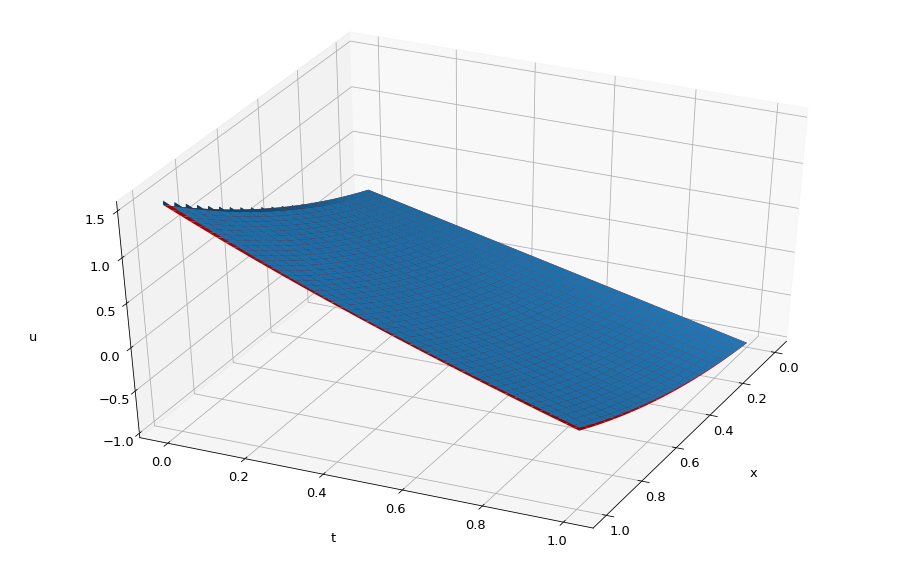

In [839]:
# solution:
x = Dim(min = 0, max = 1, N = 20)
t = Dim(min = 0, max = 1, N = 1000)

X, T, U, s = solve(x, t, boundary, initial, c, f)
U_real = exact(X, T)
plot(X, T, U, U_real)

             N    Courant      Error
  1          2       3.72   1.82e-01
  2          2       0.12   3.04e-02
  3          2       0.06   2.15e-02
  4          6       3.72   1.42e-01
  5          6       0.12   1.75e-03
  6          6       0.06   1.18e-03
  7         10       3.72   1.19e+00
  8         10       0.12   6.43e-04
  9         10       0.06   4.03e-04
 10         14       3.72   2.54e+01
 11         14       0.12   3.58e-04
 12         14       0.06   2.10e-04


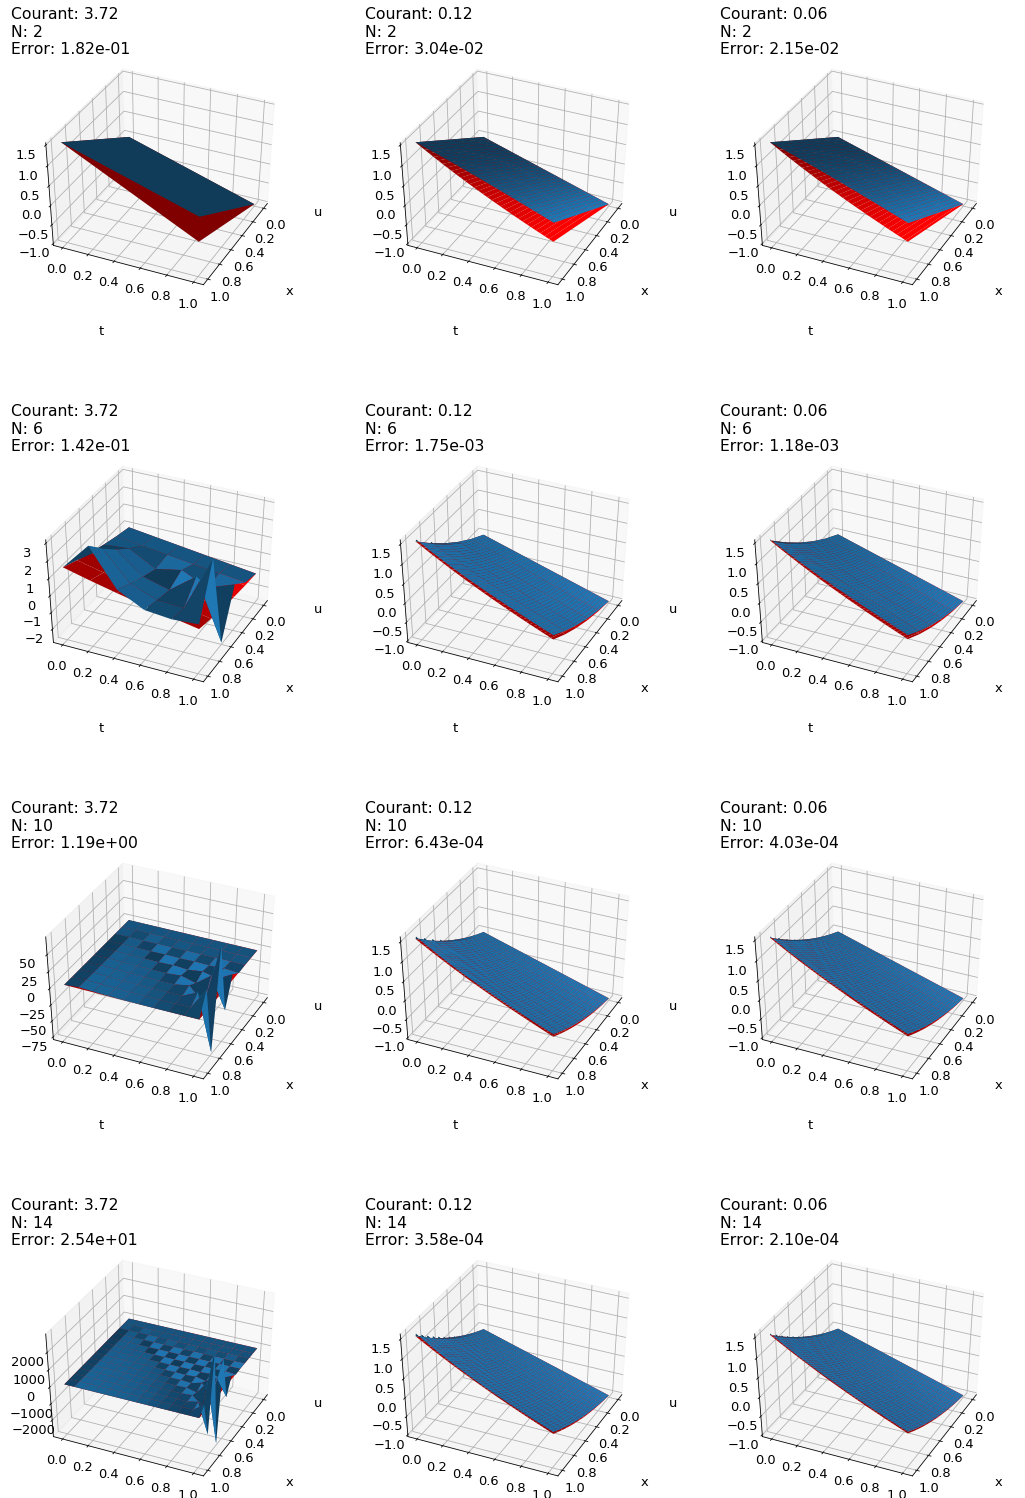

In [837]:
# Courant numbber variations

print('{: >14} {: >10} {: >10}'.format('N', 'Courant', 'Error'))
N_min = 1
N_max = 15
N_step = 4

R_min = 1
R_max = 70
R_step = 30

N_N = int((N_max - N_min - 1) / N_step) + 1
R_N = int((R_max - R_min - 1) / R_step) + 1
fig = plt.figure(figsize=(6 * R_N, 7 * N_N))

n = 1
for N in range(N_min, N_max, N_step):
    for R in range(R_min, R_max, R_step):
        # two dimensions, with step of (max-min) / N
        x = Dim(min = 0, max = 1, N = N)
        t = Dim(min = 0, max = 1, N = R * N)

        X, T, U, s = solve(x, t, boundary, initial, c, f)
        U_real = exact(X, T)
        err = np.sqrt(((U_real - U)**2).sum() / U.size / (U.size - 1))

        ax = fig.add_subplot(N_N, R_N, n, projection='3d', adjustable='box', aspect=0.8)
        ax.set_title('Courant: {:.2f}\nN: {:}\nError: {:.2e}'.format(s, x.N, err), loc='left')
        plot(X, T, U, U_real, ax)

        print('{:3d} {:10d} {:10.2f} {: >10.2e}'.format(n, x.N, s, err))
        n += 1
        